So the aim here is to create a machine learning algorithm that the company can use to determine the clients that it should target in order to enroll them as new customers. We are therefore trying to classify whether a customer is likely to buy car insurance from the company or not and hence this is a binary classification task.

HAVE TO ADD IN SOME ANALYSIS AND EVALUATION OF HOW THIS IS AN UNBALANCED DATASET 
IMPLEMENT SOMETHING LIKE THIS
1. Random Undersampling and Oversampling. A widely adopted and perhaps the most straightforward method for dealing with highly imbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and/or adding more examples from the minority class (over-sampling).

ANALYSIS SINCE WE HAVE LESS POSITIVE CASES THIS ALGORITHMS RECALL METRIC IS ESSENTIAL 
- WE WANT TO MAXIMISE THIS 

##FINISH TOMORROW 
########
##VISUALIZE FEATURES
########

In [1]:
import pickle as p 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import pandas as pd 
import seaborn as sns
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn import svm, metrics
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, GridSearchCV
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report
import scikitplot as skplt
import matplotlib.pyplot as plt

import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [2]:

train_df = pd.read_csv('C:/Users/lhaye/Documents/Genesys_Task_Dataset/carInsurance_train.csv')
test_df = pd.read_csv('C:/Users/lhaye/Documents/Genesys_Task_Dataset/carInsurance_test.csv')

print(train_df['Id'])

#LETS PUT THE COLUMNS INTO A LIST SO WE CAN SEE WHICH ONES CORRESPOND TO FEATURES AND WHICH TO 
columns = train_df.columns.tolist()
feature_columns = columns[:-1]
output_column = columns[-1:]
num_train_samples = train_df.shape[0]

print(columns)

#Okay so lets do some analysis of the data 
#print(train_df.shape)

#We can see from this that we have many categorical features which we will have to transform into numeric features
#print(train_df.info)

#Lets also check the types and we can see that the object type represents a categorical feature which we will have to change
#print(train_df.dtypes)

#Any preprocessing we do should be done in a function because we will have to do the same for the test set 
#We need to check for and deal with the following if they are present:
#1 Missing data (na or nan)
#2 Duplicate data - samples that are present twice - we can just remove one if they are identical 
#3 Modify categorical features
#4 Outliers - values that are very high for example we can see that there has been 12 previous attempts to contact one customer
#5 Create some new features from the data
#6 Remove irrelevant features/columns 
 

#Lets get the preprocessed data and then make alterations to it based on the model score 
def preprocess_data(data):
    
    print(data)
    #1 Missing data 
    #print(data.isnull().sum())
    #We can see that the columns with missing data is present where we have categorical data so when we change these 
    #to numeric data we can simply add in a value to represent NA - This should sort this issue 
    
    #2 Duplicate data
    duplicate_rows_df = data[data.duplicated()]
    #print('number of duplicate rows: ', duplicate_rows_df.shape)
    #We can see we have zero duplicated rows of data 
    
    
    #3 Modify all data that is Na with a word to avoid difficulties 
    data['Education'] = data['Education'].fillna("NoVal")
    data['Job'] = data['Job'].fillna("NoVal")
    data['Communication'] = data['Communication'].fillna("NoVal")
    data['Outcome'] = data['Outcome'].fillna("NoVal")

    #We tranlsate the categorical labels into numeric labels 
    ord_enc = OrdinalEncoder()
    #print(data)
    data["Education"] = ord_enc.fit_transform(data[["Education"]])
    data["Marital"] = ord_enc.fit_transform(data[["Marital"]])
    data["Job"] = ord_enc.fit_transform(data[["Job"]])
    data["Outcome"] = ord_enc.fit_transform(data[["Outcome"]])
    data["Communication"] = ord_enc.fit_transform(data[["Communication"]])

    #Create a feature for the duration of the call 
    data['CallStart'] = pd.to_datetime(data["CallStart"])
    data['CallEnd'] = pd.to_datetime(data["CallEnd"])

    data['CallStart'] = (data['CallStart'].dt.hour*60+data['CallStart'].dt.minute)*60 + data['CallStart'].dt.second
    data['CallEnd'] = (data['CallEnd'].dt.hour*60+data['CallEnd'].dt.minute)*60 + data['CallEnd'].dt.second
    
    data['CallDuration'] = data['CallEnd'] - data['CallStart']
    #Now we have the feature and some of the values are quite large so perhaps they should be normalised 
    
    #Now we should drop some features that we dont need 
    data = data.drop(['Id', 'LastContactDay', 'LastContactMonth', 'CallStart', 'CallEnd'], axis=1)
    
    #Now we need to normalise/put into smaller values the following columns
    # Balance
    # DaysPassed
    # NoOfContacts
    
    #NORMALIZATION WE CAN TAKE THIS OUT DEPENDENT ON WHAT ALGORITHM WE USE 
    # Maybe because the max is so infrequent we should do a different form of normalization but we can see later
    data['Balance'] = (data['Balance'] - data['Balance'].min()) / (data['Balance'].max() - data['Balance'].min())
    data['NoOfContacts'] = (data['NoOfContacts'] - data['NoOfContacts'].min()) / (data['NoOfContacts'].max() - data['NoOfContacts'].min())
    data['Age'] = (data['Age'] - data['Age'].min()) / (data['Age'].max() - data['Age'].min())
    data['DaysPassed'] = (data['DaysPassed'] - data['DaysPassed'].min()) / (data['DaysPassed'].max() - data['DaysPassed'].min())
    data['PrevAttempts'] = (data['PrevAttempts'] - data['PrevAttempts'].min()) / (data['PrevAttempts'].max() - data['PrevAttempts'].min())
    data['CallDuration'] = (data['CallDuration'] - data['CallDuration'].min()) / (data['CallDuration'].max() - data['CallDuration'].min())
    data['Job'] = (data['Job'] - data['Job'].min()) / (data['Job'].max() - data['Job'].min())
    data['Education'] = (data['Education'] - data['Education'].min()) / (data['Education'].max() - data['Education'].min())
    data['Marital'] = (data['Marital'] - data['Marital'].min()) / (data['Marital'].max() - data['Marital'].min())
    data['Communication'] = (data['Communication'] - data['Communication'].min()) / (data['Communication'].max() - data['Communication'].min())
    
    return data
    #Okay so now we have the features we need so we can return them and see how it would go on a dataset
    
    


0          1
1          2
2          3
3          4
4          5
        ... 
3995    3996
3996    3997
3997    3998
3998    3999
3999    4000
Name: Id, Length: 4000, dtype: int64
['Id', 'Age', 'Job', 'Marital', 'Education', 'Default', 'Balance', 'HHInsurance', 'CarLoan', 'Communication', 'LastContactDay', 'LastContactMonth', 'NoOfContacts', 'DaysPassed', 'PrevAttempts', 'Outcome', 'CallStart', 'CallEnd', 'CarInsurance']


In [3]:
#Take the training data and preprocess using the process outlined earlier
x_train_processed = preprocess_data(train_df)
#get the columns for the features into one list and the actual labels into another 
y_train_vals = train_df[output_column]
x_train_processed = x_train_processed.drop(labels='CarInsurance', axis=1)

        Id  Age           Job   Marital  Education  Default  Balance  \
0        1   32    management    single   tertiary        0     1218   
1        2   32   blue-collar   married    primary        0     1156   
2        3   29    management    single   tertiary        0      637   
3        4   25       student    single    primary        0      373   
4        5   30    management   married   tertiary        0     2694   
...    ...  ...           ...       ...        ...      ...      ...   
3995  3996   28    technician    single   tertiary        0        0   
3996  3997   49        admin.  divorced  secondary        0      124   
3997  3998   27        admin.    single  secondary        0     -400   
3998  3999   36  entrepreneur    single   tertiary        0      658   
3999  4000   45      services   married    primary        0      137   

      HHInsurance  CarLoan Communication  LastContactDay LastContactMonth  \
0               1        0     telephone              28  

In [4]:
#Split the data into a training and test set 
X_train, X_test, y_train, y_test = train_test_split(x_train_processed, y_train_vals, test_size=0.2, random_state=42)
y_test = y_test['CarInsurance']

           Age       Job  Marital  Education  Default   Balance  HHInsurance  \
3994  0.389610  0.181818      0.5   0.666667        0  0.030145            0   
423   0.181818  0.181818      0.5   0.333333        0  0.030136            1   
2991  0.493506  0.909091      0.5   0.666667        0  0.055344            0   
1221  0.363636  0.454545      0.5   1.000000        0  0.030136            0   
506   0.246753  0.181818      0.5   0.666667        0  0.034954            1   
...        ...       ...      ...        ...      ...       ...          ...   
1130  0.480519  0.000000      0.5   1.000000        0  0.030136            0   
1294  0.337662  0.909091      0.5   0.666667        0  0.165745            1   
860   0.298701  0.181818      0.5   0.333333        0  0.032560            0   
3507  0.194805  0.909091      0.5   0.666667        0  0.035625            0   
3174  0.181818  0.181818      0.5   0.666667        0  0.037182            1   

      CarLoan  Communication  NoOfConta

# Test for an Imbalance in the training dataset 
As we can see from the result below, this dataset is imbalanced as there are many more negative samples than positive. 

In [5]:
zeros = y_train.loc[y_train['CarInsurance'] == 0]
ones = y_train.loc[y_train['CarInsurance'] == 1]

print(len(zeros))
print(len(ones))

1912
1288


# Handling Imbalanced Data 
I will try two approached here each of which has their strenghts and weaknesses:

1. Random Under-Sampling
2. Random Over-Sampling


In [14]:
#Oversample the minority class
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X_train, y_train)

#undersample the majority class
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X_train, y_train)

# K-Fold Cross Validation 
Here I have utilisex K-Fold Cross Validations as a means of testing which algorithm performs the best. This method involves splitting the data into several different folds or groups that will each be different from eachother. Each model will then be trained and tested on the same fold and I have selected to do this 10 times. This is done randomly and thus is a much better means of evaluating performance rather than just evaluating on one train-test split of the data. Doing so will not give a fair evaluation of the results.

In [22]:
#Now lets run using k-fold cross validation to get the best 
#We will run them with some standard parameters just to get an idea of the best 3 and then do some further analysis on those
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scoring = ['accuracy']

models = [
          ('Logistic Regression', LogisticRegression()), 
          ('Support Vector Machine Linear', svm.SVC(kernel='linear', gamma='auto')),
          ('Support Vector Machine Rbf', svm.SVC(kernel='rbf', gamma='auto')),
          ('Support Vector Machine NuSVC', svm.NuSVC(gamma='auto')), 
          ('Random Forest', RandomForestClassifier(n_estimators = 100, random_state=1)),
          ('Decision Tree', DecisionTreeClassifier(max_depth=1)),
          ('K-Nearest Neighbours', KNeighborsClassifier(n_neighbors=5)), 
          ('Linear Discriminant Analysis', LinearDiscriminantAnalysis()),
          ('Naive Bayes', MultinomialNB()),
          ('Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1, random_state=1)), 
          ('Ensemble', VotingClassifier(estimators=[('boost', GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1, random_state=1)), ('SVM', svm.NuSVC(gamma='auto')) , ('rf', RandomForestClassifier(n_estimators = 100, random_state=1))], voting = 'hard'))
        ]

for name, model in models:

    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
    cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
    avg_accuracy = np.mean(cv_results['test_accuracy']) * 100 
    print(f"The {name} achieves a mean accuracy result of {avg_accuracy} over a 10-fold validation set")
    

The Logistic Regression achieves a mean accuracy result of 79.59375 over a 10-fold validation set
The Support Vector Machine Linear achieves a mean accuracy result of 80.09375000000001 over a 10-fold validation set
The Support Vector Machine Rbf achieves a mean accuracy result of 77.18749999999999 over a 10-fold validation set
The Support Vector Machine NuSVC achieves a mean accuracy result of 80.40625 over a 10-fold validation set
The Random Forest achieves a mean accuracy result of 81.9375 over a 10-fold validation set
The Decision Tree achieves a mean accuracy result of 73.625 over a 10-fold validation set
The K-Nearest Neighbours achieves a mean accuracy result of 74.62500000000001 over a 10-fold validation set
The Linear Discriminant Analysis achieves a mean accuracy result of 79.03125 over a 10-fold validation set
The Naive Bayes achieves a mean accuracy result of 65.40625 over a 10-fold validation set
The Boosting achieves a mean accuracy result of 82.0625 over a 10-fold validat

# Random Under-Sampling and Random Over-Sampling Results
As we can see below the under-sampling approach led to little or no improvement which over-sampling actually led to quite an impressive increase in performance in some of the algorithm. This can be especially be seen in the Random Forest model which previously had been the best performing algorithm. Over-Sampling led to an icnrease of almost 5% in accuracy which is a significant gain for such a simple approach. This approach is therefore highly valuable because the otehr solution would be to gather more data which as we know is a costly process. This means that from this point onwards we will train the models on the Over-Sampled datasets.

In [23]:
#Here we are going to test the over and under sampling methods to see if they helped the accuracy 
results = {}

print("Over-Sampling Results")
for name, model in models:

    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
    cv_results = model_selection.cross_validate(model, X_over, y_over, cv=kfold, scoring=scoring)
    avg_accuracy = np.mean(cv_results['test_accuracy']) * 100 
    print(f"The {name} achieves a mean accuracy result of {avg_accuracy} over a 10-fold validation set")
    results[name] = avg_accuracy

print()
print()

print("Under-Sampling Results")
for name, model in models:

    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
    cv_results = model_selection.cross_validate(model, X_under, y_under, cv=kfold, scoring=scoring)
    avg_accuracy = np.mean(cv_results['test_accuracy']) * 100 
    print(f"The {name} achieves a mean accuracy result of {avg_accuracy} over a 10-fold validation set")


Over-Sampling Results
The Logistic Regression achieves a mean accuracy result of 79.73234180416388 over a 10-fold validation set
The Support Vector Machine Linear achieves a mean accuracy result of 80.1768895328968 over a 10-fold validation set
The Support Vector Machine Rbf achieves a mean accuracy result of 79.68025918280863 over a 10-fold validation set
The Support Vector Machine NuSVC achieves a mean accuracy result of 81.66753243202602 over a 10-fold validation set
The Random Forest achieves a mean accuracy result of 86.45291375610023 over a 10-fold validation set
The Decision Tree achieves a mean accuracy result of 70.99866034202287 over a 10-fold validation set
The K-Nearest Neighbours achieves a mean accuracy result of 76.07152133200279 over a 10-fold validation set
The Linear Discriminant Analysis achieves a mean accuracy result of 79.15704072286852 over a 10-fold validation set
The Naive Bayes achieves a mean accuracy result of 63.02133883777835 over a 10-fold validation set


In [21]:
top_3_models = sorted(results, key=results.get, reverse=True)[:3]

for i in range(len(top_3_models)):
    if(i == 0):
        print("The models with the top 3 results are: ")
        print("-", top_3_models[i])
    else:
        print("-", top_3_models[i])

The models with the top 3 results are: 
- Random Forest
- Ensemble
- Boosting


# Hyperparameter Tuning using Grid-Search

Here I have carried out grid-search for each of the three top performing algorithms. Grid-search involves testing all combinations of the chosen hyperparameters and is a very effective means of exhaustively testing the chosen combinations fo the hyperparameters in an aim to get the best combination. This is an NP hard problem however and grows exponentially in time complexity as more parameters are added. It is worth noting that this appears to have actually reduced the performance whic is unusual and had I more time I would analyse these parameters further. When I did this analysis without the Over-Sampling being implemented these were the parameters wo perhaps since this has changed the optimal paramaeters have also changes. I would run this again but the search takes many hours. 

In [348]:
#Now lets take the top 3 and get the best parameters using grid search and then do some analysis of the scores of them
#('Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1, random_state=1)), 
#('Random Forest', RandomForestClassifier(n_estimators = 100, random_state=1)),
#('Support Vector Machine NuSVC', svm.NuSVC(gamma='auto')), 

RFModel = RandomForestClassifier(random_state=1)

#By doing this grid search we are essentially searching for the parameters that reduce overfitting the most

param_grid  = { 
    #Number of trees to create 
    #The more this is the less likely overfitting is as it becomes less and less like a decision tree 
    'n_estimators': [40, 60, 80, 100, 200, 500],
    #How many features we consider per tree as a starting point 
    #The lower this is the less likely overfitting is 
    'max_features': ['auto', 'sqrt', 'log2'],
    #How large is the trees max depth 
    'max_depth' : [5,6,7,8,9,10,13],
    #Which impurity measure to use in the split
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=RFModel, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)


#Grid search for Boosting 
BoostingModel = GradientBoostingClassifier(random_state=1)

param_grid  = { 
    #Number of boosting stages to carry out 
    'n_estimators': [100, 200, 400, 500, 800],
    #How many features we consider per tree as a starting point 
    'learning_rate': [0.001, 0.005, 0.01, 0.1, 0.5],
    #How large is the trees max depth 
    'max_depth' : [3,4,5,7,9],
    #Which impurity measure to use in the split
    'max_features': ['auto', 'sqrt', 'log2'],
}

CV_rfc = GridSearchCV(estimator=BoostingModel, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)


SVMModel = svm.NuSVC()

param_grid = {'nu': [0.1, 0.3, 0.5, 0.7, 0.9], 
              'gamma': ['scale', 'auto'],
              'kernel': ['linear', 'poly', 'rbf']}

CV_SVM = GridSearchCV(estimator=SVMModel, param_grid=param_grid, cv= 5)
CV_SVM.fit(X_train, y_train)
print(CV_SVM.best_params_)


{'learning_rate': 0.01, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 500}


# Improvement in Results Post Grid-Search

In [24]:
#Best parameters for the Random Forest Model
#{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 60}
RFModel = RandomForestClassifier(criterion= 'entropy', max_depth= 8, max_features= 'auto', n_estimators= 60, random_state=1)

#Best parameters for the Boosting Model
#{'learning_rate': 0.01, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 500}
BoostingModel = GradientBoostingClassifier(learning_rate=0.01, max_depth=5, max_features='sqrt', n_estimators=500, random_state=1)

#Best parameters for the SVM Model 
#{'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.5}
SVMModel = svm.NuSVC(gamma = 'auto', kernel = 'rbf', nu = 0.5)

#Ensemble model combines all 3 
Ensemble = VotingClassifier(estimators=[('boost', BoostingModel), ('SVM', SVMModel) , ('rf', RFModel)], voting = 'hard')

models = [
          ('Random Forest Model', RFModel),
          ('Support Vector Machine NuSVC', SVMModel), 
          ('Boosting', BoostingModel), 
          ('An Ensemble', Ensemble)
        ]

for name, model in models:

    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
    cv_results = model_selection.cross_validate(model, X_over, y_over, cv=kfold, scoring=scoring)
    avg_accuracy = np.mean(cv_results['test_accuracy']) * 100 
    print(f"The {name} achieves a mean accuracy result of {avg_accuracy} over a 10-fold validation set")

The Random Forest Model achieves a mean accuracy result of 84.41342118573401 over a 10-fold validation set
The Support Vector Machine NuSVC achieves a mean accuracy result of 81.66753243202602 over a 10-fold validation set
The Boosting achieves a mean accuracy result of 84.25683157218432 over a 10-fold validation set
The An Ensemble achieves a mean accuracy result of 84.30884584364279 over a 10-fold validation set


In [25]:
#Boosting is the best algorithm so lets do some analysis 

#This will give the Precision, Recall and the F1 score
print("Results for the Boosting Model: ")
BoostingModel.fit(X_over, y_over)
Boosting_predictions = BoostingModel.predict(X_test)
BoostingReport = classification_report(y_test, Boosting_predictions)
print(BoostingReport)

print()
print()

print("Results for the Ensemble Model: ")

Ensemble.fit(X_over, y_over)
Ensemble_predictions = Ensemble.predict(X_test)
EnsembleReport = classification_report(y_test, Ensemble_predictions)
print(EnsembleReport)

print()
print()

print("Results for the Random Forest Model: ")
RFModel.fit(X_over, y_over)
RFModel_predictions = RFModel.predict(X_test)
RFModelReport = classification_report(y_test, RFModel_predictions)
print(RFModelReport)

print()
print()

print("Results for the SVM Model: ")
SVMModel.fit(X_over, y_over)
SVM_predictions = SVMModel.predict(X_test)
SVMReport = classification_report(y_test, SVM_predictions)
print(SVMReport)



Results for the Boosting Model: 
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       484
           1       0.75      0.83      0.78       316

    accuracy                           0.82       800
   macro avg       0.81      0.82      0.81       800
weighted avg       0.83      0.82      0.82       800



Results for the Ensemble Model: 
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       484
           1       0.76      0.84      0.79       316

    accuracy                           0.83       800
   macro avg       0.82      0.83      0.82       800
weighted avg       0.83      0.83      0.83       800



Results for the Random Forest Model: 
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       484
           1       0.74      0.84      0.79       316

    accuracy                           0.82       800
   macro avg       0

# Confusion Matrix Evalution
When looking at this problem where we are aiming to correctly classify whether a person will be a good candidate to cold call I believe that a successful algorithm should be aiming to have as high of an accuracy as possible. However, I also believe it is essential to have true negatives as high as possible as these are the people who will in fact buy the insurance. Therefore, we are aiming to reduce the false positive number. This may seem counter intuative as we would imagine the true positives to be the people who we correctly predicted to be the people who will purchase the insurance but as we can see in the confusion matric the right side of the matrix representes the lesser number of samples (imbalanced data). Therefore, I believe that the algorithm that has the best ratio of false positives to true negatives is best because we want to minimize the number of people that would buy the insurance that we do not ring. A call to a user who does not want to buy the insurance could be less segnificant than not calling a customer that would buy it. Thus, the Boosting algorithm is probably best as it appears to have the best balance.

In [26]:
#This will give us a confusion martrix with True Positive, True Negative, False Positive and False Negatives

print("Boosting Model Confusion Matrix:")
matrix = confusion_matrix(y_test, Boosting_predictions)
print(matrix)

print()
print()

print("Ensemble Model Confusion Matrix:")
matrix = confusion_matrix(y_test, Ensemble_predictions)
print(matrix)

print()
print()

print("Random Forest Model Confusion Matrix:")
matrix = confusion_matrix(y_test, RFModel_predictions)
print(matrix)

print()
print()

print("SVM Model Confusion Matrix:")
matrix = confusion_matrix(y_test, SVM_predictions)
print(matrix)


Boosting Model Confusion Matrix:
[[395  89]
 [ 55 261]]


Ensemble Model Confusion Matrix:
[[399  85]
 [ 52 264]]


Random Forest Model Confusion Matrix:
[[390  94]
 [ 49 267]]


SVM Model Confusion Matrix:
[[402  82]
 [ 67 249]]


In [27]:
#Save the models that we will use in the REST API
p.dump(RFModel, open('RandomForest.pickle', 'wb'))
p.dump(BoostingModel, open('BoostingModel.pickle', 'wb'))

# ROC Curve and Area Under ROC Curve Evaluation
The ROC curve illustrates the trade-off between the true positive rate (Recall) and 1 - the true negative rate. 
##FINISH TOMORROW

In [28]:
#This will give the Area Under the ROC Curve
scoring = 'roc_auc'
results = model_selection.cross_val_score(BoostingModel, X_test, y_test, cv=kfold, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

results = model_selection.cross_val_score(RFModel, X_test, y_test, cv=kfold, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

results = model_selection.cross_val_score(SVMModel, X_test, y_test, cv=kfold, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

AUC: 0.889 (0.040)
AUC: 0.888 (0.038)
AUC: 0.888 (0.037)


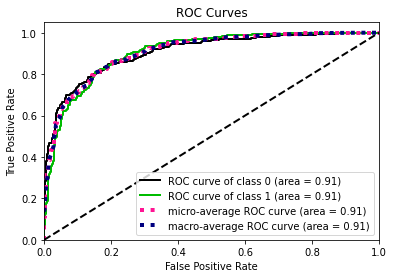

In [29]:
#ROC Curve for the Boosting Model
y_preds = BoostingModel.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_preds)
plt.show()

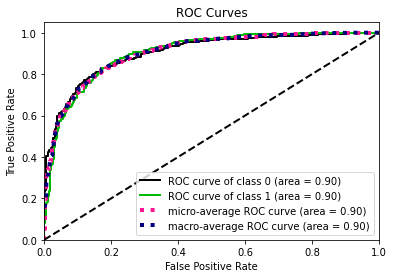

In [30]:
#ROC Curve for the Random Forest Model
y_preds = RFModel.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_preds)
plt.show()

In [34]:
#Do some preprocessing on the test data
x_test_processed = preprocess_data(test_df)
x_test_processed = x_test_processed.drop(labels='CarInsurance', axis=1)
y_test_vals = test_df[output_column]

       Id  Age         Job  Marital  Education  Default  Balance  HHInsurance  \
0    4001   25      admin.   single  secondary        0        1            1   
1    4002   40  management  married   tertiary        0        0            1   
2    4003   44  management   single   tertiary        0    -1313            1   
3    4004   27    services   single  secondary        0     6279            1   
4    4005   53  technician  married  secondary        0     7984            1   
..    ...  ...         ...      ...        ...      ...      ...          ...   
995  4996   31      admin.   single  secondary        0      131            1   
996  4997   52  management  married   tertiary        0     2635            0   
997  4998   46  technician  married   tertiary        0     3009            0   
998  4999   60     retired  married  secondary        0     7038            0   
999  5000   28  management   single   tertiary        0      957            0   

     CarLoan Communication 

# REST API Unit Testing

Here I have included some unit tests to test the functionality of the REST API. It is worth noting that if this were to be for a production system the testing would have to be much more rigerous and many more test would be included. 

In [324]:
#and here will be the client 
import requests
import json
import unittest

#This is to test the predictions of new samples
def test_predictions():

    url = 'http://127.0.0.1:1080/algorithm' 

    #Test a sample that is predicted as a 0
    new = x_test_processed.iloc[0].to_json(orient='split')

    response = requests.post(url, json=new)
    expected_res = {'Prediction': 0}
    assert response.json() == expected_res, "Should have returned a 0"


    #Test a sample that is predicted as a 1
    new = x_test_processed.iloc[7].to_json(orient='split')

    response = requests.post(url, json=new)
    expected_res = {'Prediction': 1}
    assert response.json() == expected_res, "Should have returned a 1"



#This is to test the predictions of new samples
def test_retraining():

    url = 'http://127.0.0.1:1080/retrain' 

    X_train['CarInsurance'] = y_train 
    comb_df = X_train

    new = comb_df.to_json(orient='split')

    response = requests.post(url, json=new)
    expected_res = 200
    print(response.json())
    assert response.json() == expected_res, "Should have seen a return code of 200"


#This is to test the changing of the model
def test_modelChange():

    #Now we want to change the model 
    url = 'http://127.0.0.1:1080/change_model' 

    new_model = {"model":"BoostingModel.pickle"}

    model_json = json.dumps(new_model)

    response = requests.post(url, json=model_json)
    expected_res = 200
    print(response.json())

    assert response.json() == expected_res, "Should have seen a return code of 200"


#This is to test the method to get the model we are using 
def test_modelName():
    
    #Now we want to check which model is in use  
    #As we can see this method can be used to unit test the functionality of changing the model 
    url = 'http://127.0.0.1:1080/algorithm'  

    response = requests.get(url)
    expected_res = "GradientBoostingClassifier"
    print(response.json())

    assert response.json() == expected_res, "Should have seen a return code of 200"


#This is to test the retrieving all the data from the database
def test_dataRetrieval(empty_test):
    
    #Now we will check that we can retrive all of the database samples
    url = 'http://127.0.0.1:1080/database'  
    
    if (empty_test == False):
        response = requests.get(url)
        print(response.json())

        assert len(response.json()) >= 1, "Should have seen a return code of 200"
    else:
        response = requests.get(url)
        print(response.json())
        expected_res = "The database is empty"

        assert response.json() == expected_res, "Should see a database empty error"      

#This is to test updating the database sample at a specified index with new data 
def test_dataUpdate():
    
    url = 'http://127.0.0.1:1080/database'  

    index = 0
    data = x_test_processed.iloc[0, :]

    data['index'] = index

    model_json = data.to_json(orient = 'columns')
    expected_res = 200

    response = requests.put(url, json=model_json)
    print(response.json())
    assert response.json() == expected_res, "Should have seen a return code of 200"
    
    index = 50
    data = x_test_processed.iloc[0, :]

    data['index'] = index

    model_json = data.to_json(orient = 'columns')
    expected_res = "Error - The sample index supplied is not in the database"

    response = requests.put(url, json=model_json)
    print(response.json())
    assert response.json() == expected_res, "Should have seen an error code as the index is too big"


#This is a test to see if the data entry at a specified index is deleted correctly
def test_deletion():

    #Now we test to make sure we can delete records from the database 
    url = 'http://127.0.0.1:1080/database'  

    #Test an example where we can delete the data
    index = "0"
    model_json = json.dumps(0)
    expected_res = 200
    response = requests.delete(url, json=model_json)
    assert response.json() == expected_res, "Should have seen a return code of 200"

    #Test one that is out of bounds so we are testing the error detection
    index = "50"
    model_json = json.dumps(0)
    response = requests.delete(url, json=model_json)    
    expected_res = "Error - The sample index supplied is not in the database"
    assert response.json() == expected_res, "Should have seen an error code to say index is not in database"


#When working with production level code we will have to unit test each possible case 



In [325]:
if __name__ == "__main__":
    test_dataRetrieval(True)
    test_predictions()
    test_retraining()
    test_modelChange()
    test_modelChange()
    test_dataRetrieval(False)
    test_dataUpdate()
    
    print("Everything passed")
    


The database is empty
200
200
200
{"0": [0.0945945946, 0.0909090909, 1.0, 0.6666666667, 0.0, 0.0454253612, 1.0, 1.0, 0.0, 0.3333333333, 0.0, 0.0, 0.0, 0.0058631922], "1": [1.4324324324, 1.4545454545, 1.5, 2.0, 1.0, 1.0548956661, 2.0, 1.0, 1.5, 1.0, 1.5161839864, 1.15, 2.0, 1.2283387622]}
200
Error - The sample index supplied is not in the database
Everything passed


In [17]:
import warnings
warnings.filterwarnings('ignore')